In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Monthly Air Passengers from January 1949 to December 1960
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### 8.3.2 Forecasting with a SARIMA(p,d,q)(P,D,Q)_m model

In [3]:
# Pg 172

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060441
p-value: 0.9918802434376409


In [4]:
df['Passengers'].tail() #$hape (144,)

139    606
140    508
141    461
142    390
143    432
Name: Passengers, dtype: int64

In [11]:
# Pg 172

df_diff = np.diff(df['Passengers'], n=12)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.343415591614377
p-value: 2.9805039722072167e-29


In [12]:
df_diff.std()

np.float64(16349.852923006283)

In [6]:
df_diff

array([   6,   14,   -3,   -8,   14,   13,    0,  -12,  -17,  -15,   14,
         -3,   11,   15,   -6,  -10,   24,   21,    0,  -12,  -25,  -19,
         26,    5,    5,   28,  -15,    9,    6,   21,    0,  -15,  -22,
        -16,   20,    5,    9,   13,  -12,    2,   35,   12,   12,  -33,
        -18,  -19,   22,    2,    0,   40,   -1,   -6,   14,   21,    8,
        -35,  -26,  -31,   21,    3,  -16,   47,   -8,    7,   30,   38,
         -9,  -34,  -30,  -26,   26,   13,   -9,   34,    2,    1,   45,
         49,  -17,  -35,  -38,  -37,   41,    6,   -7,   40,   -4,    5,
         56,   39,   -8,  -50,  -49,  -35,   35,    9,  -14,   55,   -8,
          7,   67,   43,    2,  -63,  -57,  -42,   31,    4,  -22,   44,
        -14,   15,   72,   56,   14, -101,  -45,  -49,   27,   23,  -18,
         64,  -10,   24,   52,   76,   11,  -96,  -56,  -45,   43,   12,
        -26,   28,   42,   11,   63,   87,  -16,  -98,  -47,  -71,   42])

In [13]:
# Pg 172

df_diff_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -20.158826346848848
p-value: 0.0


In [14]:
df_diff_diff.std()

np.float64(48464816.50525068)

In [8]:
df_diff_diff

array([   8,  -17,   -5,   22,   -1,  -13,  -12,   -5,    2,   29,  -17,
         14,    4,  -21,   -4,   34,   -3,  -21,  -12,  -13,    6,   45,
        -21,    0,   23,  -43,   24,   -3,   15,  -21,  -15,   -7,    6,
         36,  -15,    4,    4,  -25,   14,   33,  -23,    0,  -45,   15,
         -1,   41,  -20,   -2,   40,  -41,   -5,   20,    7,  -13,  -43,
          9,   -5,   52,  -18,  -19,   63,  -55,   15,   23,    8,  -47,
        -25,    4,    4,   52,  -13,  -22,   43,  -32,   -1,   44,    4,
        -66,  -18,   -3,    1,   78,  -35,  -13,   47,  -44,    9,   51,
        -17,  -47,  -42,    1,   14,   70,  -26,  -23,   69,  -63,   15,
         60,  -24,  -41,  -65,    6,   15,   73,  -27,  -26,   66,  -58,
         29,   57,  -16,  -42, -115,   56,   -4,   76,   -4,  -41,   82,
        -74,   34,   28,   24,  -65, -107,   40,   11,   88,  -31,  -38,
         54,   14,  -31,   52,   24, -103,  -82,   51,  -24,  113])

It was stationary after the first seasonal differencing. We can see how after the second seasonal differencing, the standard deviation increases

Still, we will proceed to experiment. We will do d=0 and D=1 in another file. Here, d=0 and D=2

In [9]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# Pg 174

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12] # len 132
#test = df['Passengers'][-12:]  # len 12

d = 0
D = 2
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 0, 0, 2)",827.308021
1,"(2, 0, 1, 1)",828.136444
2,"(1, 1, 0, 2)",828.526881
3,"(2, 0, 1, 2)",829.044158
4,"(3, 0, 0, 2)",829.226633
...,...,...
251,"(0, 0, 0, 1)",947.050360
252,"(0, 1, 0, 0)",956.548611
253,"(0, 0, 2, 0)",962.391613
254,"(0, 0, 1, 0)",968.033848


In [ ]:
SARIMA_result_df[10:20]

***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(2,0,0)(0,2,2)_12, which has the lowest AIC

In [15]:
SARIMA_model = SARIMAX(train, order=(2,0,0), seasonal_order=(0,2,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 2, [1, 2], 12)   Log Likelihood                -410.266
Date:                                 Tue, 10 Feb 2026   AIC                            830.533
Time:                                         14:10:59   BIC                            843.943
Sample:                                              0   HQIC                           835.970
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5873      0.101      5.816      0.000       0.389       0

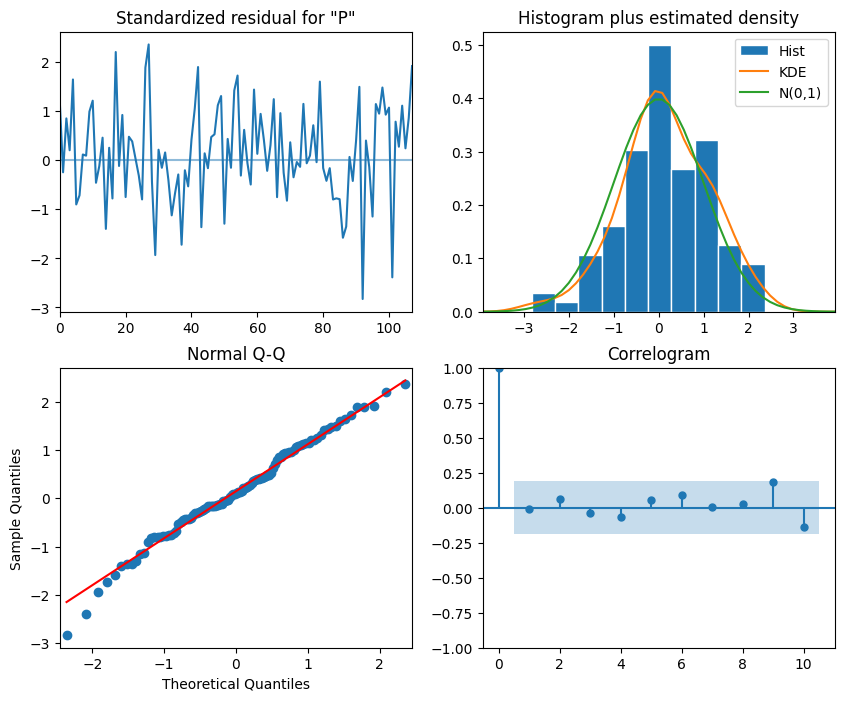

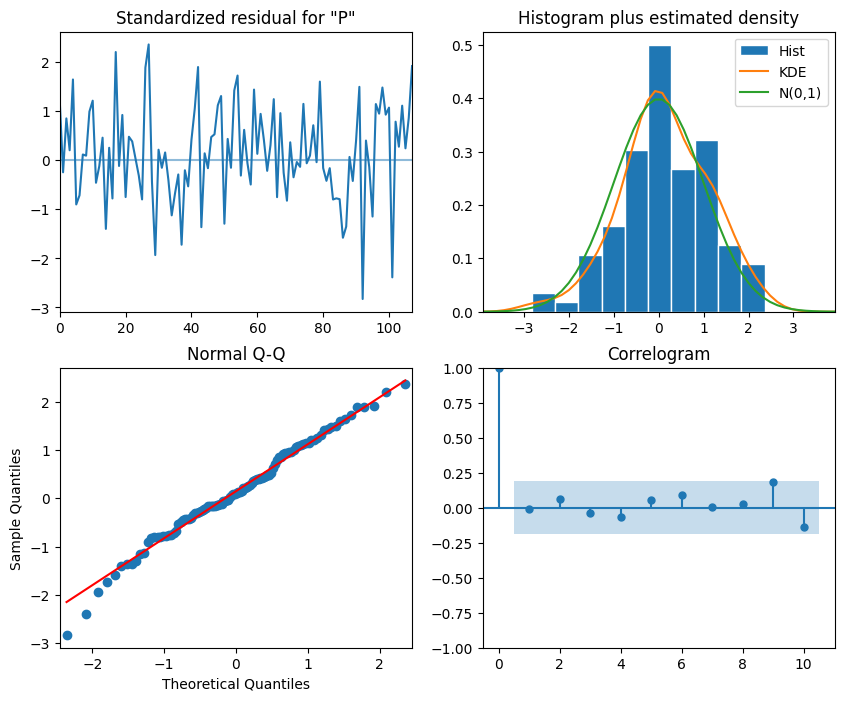

In [16]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [17]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,96.482689,9.002755e-23
2,175.733855,6.916370e-39
3,232.890272,3.280113e-50
4,271.485013,1.526448e-57
5,294.275463,1.703197e-61
6,305.312780,5.946505e-63
7,308.575528,8.912020e-63
8,308.804073,5.499466e-62
9,309.317412,2.751814e-61
10,313.969180,1.725090e-61


SARIMA(2,0,0)(0,2,2)_12, Ljung-Box test we can reject null hypothesis for lags 1 to lag 20  

Still, let's forecase just to experiment

*******************************************************************************************
Forecast with model

In [20]:
SARIMA_model = SARIMAX(train, order=(2,0,0), seasonal_order=(0,2,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
#print(SARIMA_model_fit.summary())

In [21]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [22]:
# Pg 175

SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,SARIMA_pred
132,1960-01,417,360,417.655593
133,1960-02,391,342,393.907654
134,1960-03,419,406,456.309926
135,1960-04,461,396,441.538265
136,1960-05,472,420,465.955896
137,1960-06,535,472,526.220782
138,1960-07,622,548,604.810994
139,1960-08,606,559,618.786895
140,1960-09,508,463,505.511311
141,1960-10,461,407,445.399994


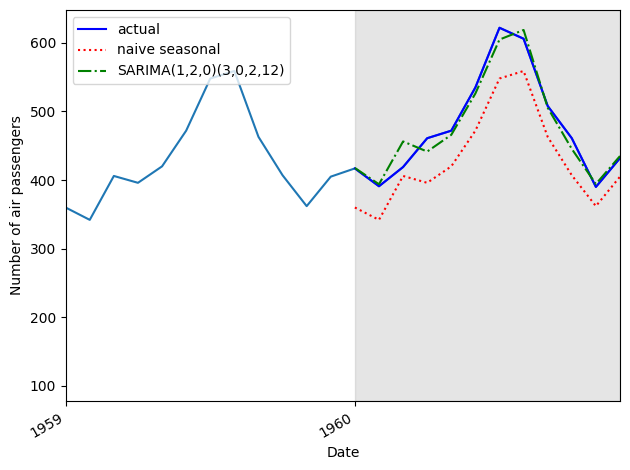

In [23]:
# Figure 8.13 in pg 176

fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,2,0)(3,0,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()


In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
#mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

9.987532920823485 2.2899642917270775


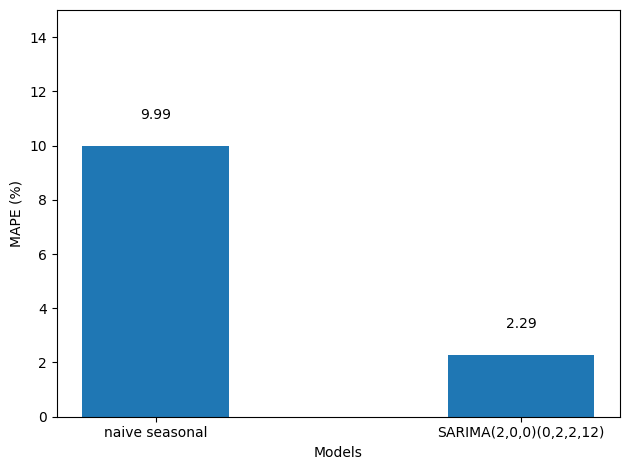

In [28]:
# Figure 8.14 in pg 177

fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,0,0)(0,2,2,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)

d=0. D=2, SARIMA(2,0,0)(0,2,2)_12: 2.29% off

d=1, D=1, SARIMA(2,1,1)(1,1,2)_12: 2.85% off
